# For AROUSAL

https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d

In [62]:
from os import listdir
from os.path import isfile, join
mypath = "/Users/apple/Desktop/eeglab14_1_2b/Granger Casuality/img/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [63]:
onlyfiles.sort()

In [64]:
from matplotlib import image
from matplotlib import pyplot
import numpy as np
from PIL import Image

In [65]:
X = []
for i in range(len(onlyfiles)):
    data = Image.open(mypath + onlyfiles[i])
    arr = np.array(data)
    result = np.zeros((32,32))
    toadd = np.zeros((32,32,4))
    for k in range(arr.shape[2]):
        result[:arr[:,:,k].shape[0],:arr[:,:,k].shape[1]] = arr[:,:,k] 
        toadd[:,:,k] = result
    X.append(toadd)
print(len(X))
print(X[1].shape)

1280
(32, 32, 4)


In [66]:
import pandas as pd
df = pd.read_csv('/Users/apple/Desktop/eeglab14_1_2b/participant_ratings.csv',
                sep=r'\s*,\s*',engine = 'python', na_values = '?')
df.dropna()
Y_chart = pd.get_dummies(df, drop_first=True)
Y = Y_chart['Arousal'].tolist()
print(len(Y))

1280


In [67]:
for i in range(len(Y)):
    if Y[i] < 5:
        Y[i] = 0
    else:
        Y[i] = 1
print(len(Y))

1280


In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(40/len(Y)))

In [70]:
import numpy as np
X_train_temp = np.asarray(X_train)
Y_train_temp = np.asarray(y_train)
print('Image dataset have shape =', X_train_temp.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train_temp.min(),
                        X_train_temp.mean(), X_train_temp.std(), X_train_temp.max()))
print('')
print('Train label has shape =', Y_train_temp.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y_train_temp.min(),
                        Y_train_temp.mean(), Y_train_temp.std(), Y_train_temp.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 1.00/139.57/79.39/255.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.59/0.49/1.00


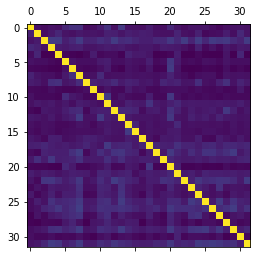

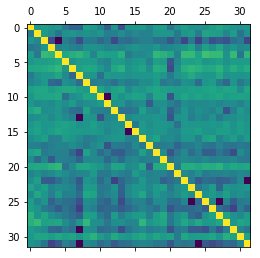

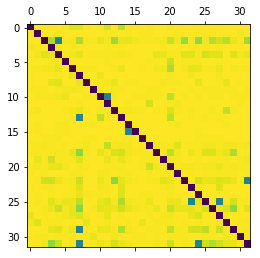

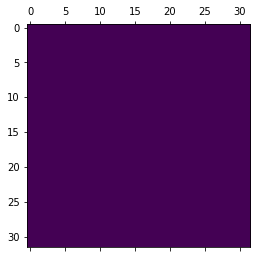

In [96]:
pyplot.matshow(X_train[0][:,:,0])
pyplot.matshow(X_train[0][:,:,1])
pyplot.matshow(X_train[0][:,:,2])
pyplot.matshow(X_train[0][:,:,3])

In [97]:
for x in X_train:
    x = x[:,:,0:3]
for x in X_test:
    x = x[:,:,0:3]

In [98]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [99]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.FloatTensor(y_train)

In [100]:
trainset = utils.TensorDataset(tensor_x,tensor_y)

In [101]:
trainloader = utils.DataLoader(trainset,  batch_size= 40)

In [102]:
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test])
tensor_y_test = torch.FloatTensor(y_test)

In [103]:
testset = utils.TensorDataset(tensor_x_test,tensor_y_test)
testloader = utils.DataLoader(testset,  batch_size=40)

In [104]:
device = torch.device("cpu")
classes = ('Positive', 'Negative')
print(device)

cpu


In [105]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [106]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images = images.permute(0, 3, 1, 2)
print(images.size())

torch.Size([40, 32, 32, 4])
torch.Size([40, 4, 32, 32])


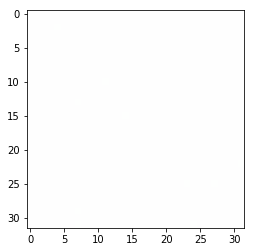

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
rows = 1
columns = 1
fig=plt.figure()
for i in range(1):
    fig.add_subplot(rows, columns, i+1)
    img = images[i]
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()

In [108]:
num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [111]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.0005)
avg_losses = [] 
epochs = 1000 
print_freq = 50 
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Finished Training.


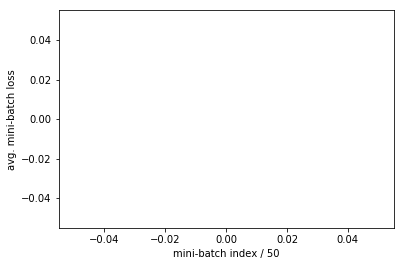

In [112]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [114]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 60 %


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [119]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        one = torch.tensor(1, dtype=torch.float, device=device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'other'

In [37]:
'''
kernal size 3*3
step size = 1
maximum pooled layer of 2*2
step size = 2
learning rate = 0.0001
batch size = 63
dropout rate = 0.5
k-fold: 5-fold cross validation
'''

'\nkernal size 3*3\nstep size = 1\nmaximum pooled layer of 2*2\nstep size = 2\nlearning rate = 0.0001\nbatch size = 63\ndropout rate = 0.5\nk-fold: 5-fold cross validation\n'